Finished 10.00 percent in 0.177681 s Acceptance rate = 0

/tmp/ipykernel_5116/1952621617.py:60: RuntimeWarning: invalid value encountered in log
  log_prior_val += np.log(hd_corr)  # Add log of the HD correlation


Finished 100.00 percent in 1.793912 s Acceptance rate = 0
Run Complete


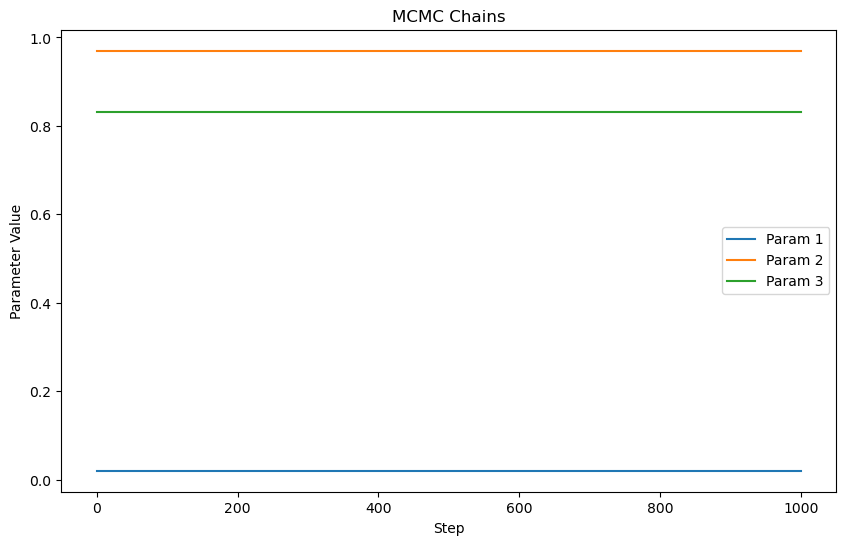

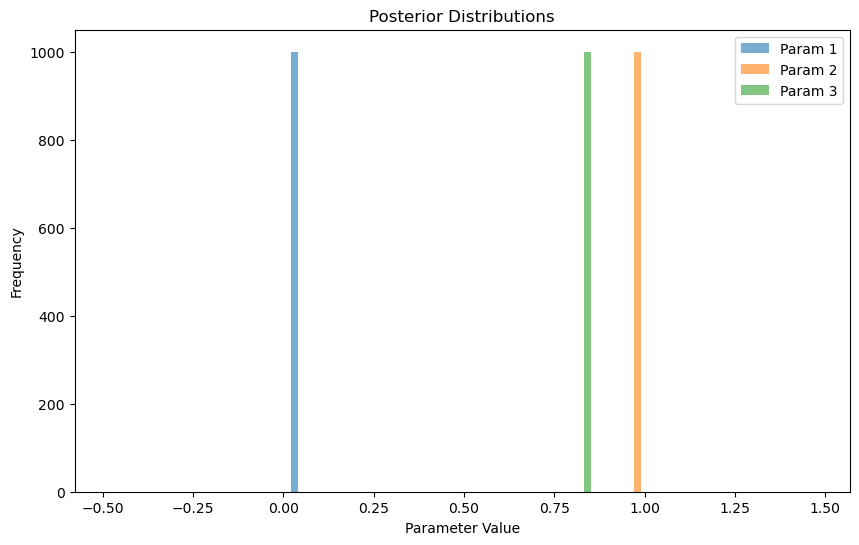

In [5]:
import numpy as np
from PTMCMCSampler.PTMCMCSampler import PTSampler
import matplotlib.pyplot as plt

def angular_separation(pos1, pos2):
    """
    Compute the angular separation between two pulsars.
    
    Parameters:
    - pos1, pos2: Arrays containing (RA, Dec) in radians for the two pulsars.
    
    Returns:
    - theta: Angular separation in radians.
    """
    ra1, dec1 = pos1
    ra2, dec2 = pos2

    delta_ra = ra2 - ra1
    cos_theta = np.sin(dec1) * np.sin(dec2) + np.cos(dec1) * np.cos(dec2) * np.cos(delta_ra)
    return np.arccos(np.clip(cos_theta, -1.0, 1.0))


def hellings_downs_correlation(theta):
    """
    Compute the Hellings-Downs correlation for a given angular separation.
    
    Parameters:
    - theta (float or ndarray): Angular separation in radians between two pulsars.
    
    Returns:
    - hd_corr (float or ndarray): Hellings-Downs correlation value.
    """
    small_angle = 1e-10
    theta = np.clip(theta, small_angle, np.pi)

    hd_corr = (1.0 / 2) * (1 + np.cos(theta)) * np.log(1 + np.cos(theta)) \
              - (1.0 / 6) * (1 - np.cos(theta))

    return hd_corr


def log_prior(params, pulsar_positions):
    """
    Compute the log prior for the Hellings-Downs correlation.
    
    Parameters:
    - params: Model parameters (e.g., amplitude of GW background, noise parameters).
    - pulsar_positions: Array of pulsar positions [(RA, Dec), ...] in radians.
    
    Returns:
    - log_prior_val: Logarithm of the prior probability.
    """
    n_pulsars = len(pulsar_positions)
    log_prior_val = 0.0

    for i in range(n_pulsars):
        for j in range(i + 1, n_pulsars):
            theta = angular_separation(pulsar_positions[i], pulsar_positions[j])
            hd_corr = hellings_downs_correlation(theta)
            log_prior_val += np.log(hd_corr)  # Add log of the HD correlation

    # Example: Return a broad Gaussian prior for model parameters
    log_prior_val += -0.5 * np.sum((params / 10.0) ** 2)  # Assuming params ~ N(0, 10)
    return log_prior_val


def log_likelihood(params):
    """
    Placeholder log-likelihood function for the MCMC.
    You should replace this with your actual PTA likelihood.
    
    Parameters:
    - params: Model parameters.
    
    Returns:
    - log_likelihood_val: Logarithm of the likelihood.
    """
    # Example: A toy likelihood (normally distributed residuals)
    return -0.5 * np.sum((params - 5.0) ** 2)


# Define the number of pulsars and their positions (RA, Dec) in radians
n_pulsars = 5
np.random.seed(42)  # For reproducibility
pulsar_positions = np.random.rand(n_pulsars, 2) * np.array([2 * np.pi, np.pi]) - np.array([0, np.pi / 2])

# Define the initial parameters for the sampler
n_params = 3  # Example: 3 model parameters
initial_params = np.random.rand(n_params)

# Set up the PTMCMC sampler
sampler = PTSampler(
    ndim=n_params,
    logl=log_likelihood,
    logp=lambda params: log_prior(params, pulsar_positions),
    cov=np.eye(n_params) * 0.1,  # Initial covariance matrix for jumps
)

# Run the sampler
n_samples = 10000
sampler.sample(initial_params, n_samples)

# Access the chain
if len(sampler._chain.shape) == 2:  # Single-temperature sampler
    samples = sampler._chain  # Shape: [n_iter, n_params]
elif len(sampler._chain.shape) == 3:  # Parallel tempering
    samples = sampler._chain[0, :, :]  # Coldest chain
else:
    raise ValueError(f"Unexpected chain shape: {sampler._chain.shape}")

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(n_params):
    plt.plot(samples[:, i], label=f"Param {i+1}")
plt.xlabel("Step")
plt.ylabel("Parameter Value")
plt.title("MCMC Chains")
plt.legend()
plt.show()

# Posterior distributions
plt.figure(figsize=(10, 6))
for i in range(n_params):
    plt.hist(samples[:, i], bins=50, alpha=0.6, label=f"Param {i+1}")
plt.xlabel("Parameter Value")
plt.ylabel("Frequency")
plt.title("Posterior Distributions")
plt.legend()
plt.show()

/tmp/ipykernel_5116/1952621617.py:36: RuntimeWarning: divide by zero encountered in log
  hd_corr = (1.0 / 2) * (1 + np.cos(theta)) * np.log(1 + np.cos(theta)) \
/tmp/ipykernel_5116/1952621617.py:36: RuntimeWarning: invalid value encountered in multiply
  hd_corr = (1.0 / 2) * (1 + np.cos(theta)) * np.log(1 + np.cos(theta)) \


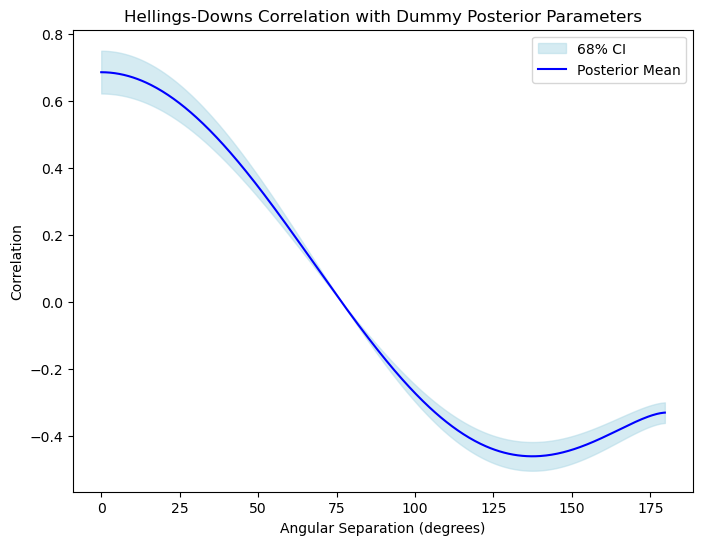

In [11]:
# Define angular separations
theta_degrees = np.linspace(0, 180, 500)  # Angular separations in degrees
theta_radians = np.radians(theta_degrees)

# Use MCMC samples (replace `samples` with your actual posterior samples)
# For this example, we'll use random values as a placeholder
# Example: Suppose we have 100 posterior samples of some scaling factor
n_samples = 100  # Number of posterior samples
np.random.seed(42)
posterior_samples = np.random.normal(loc=1.0, scale=0.1, size=n_samples)  # Example posterior

# Compute Hellings-Downs correlation for each posterior sample
hd_posterior = []
for param in posterior_samples:
    hd_posterior.append(param * hellings_downs_correlation(theta_radians))

hd_posterior = np.array(hd_posterior)

# Compute posterior mean and 68% credible intervals
hd_mean = np.mean(hd_posterior, axis=0)
hd_lower = np.percentile(hd_posterior, 16, axis=0)
hd_upper = np.percentile(hd_posterior, 84, axis=0)

# Plot the Hellings-Downs correlation with posterior uncertainty
plt.figure(figsize=(8, 6))
plt.fill_between(theta_degrees, hd_lower, hd_upper, color="lightblue", alpha=0.5, label="68% CI")
plt.plot(theta_degrees, hd_mean, color="blue", label="Posterior Mean")
plt.xlabel("Angular Separation (degrees)")
plt.ylabel("Correlation")
plt.title("Hellings-Downs Correlation with Dummy Posterior Parameters")
plt.legend()
# plt.grid()
plt.show()

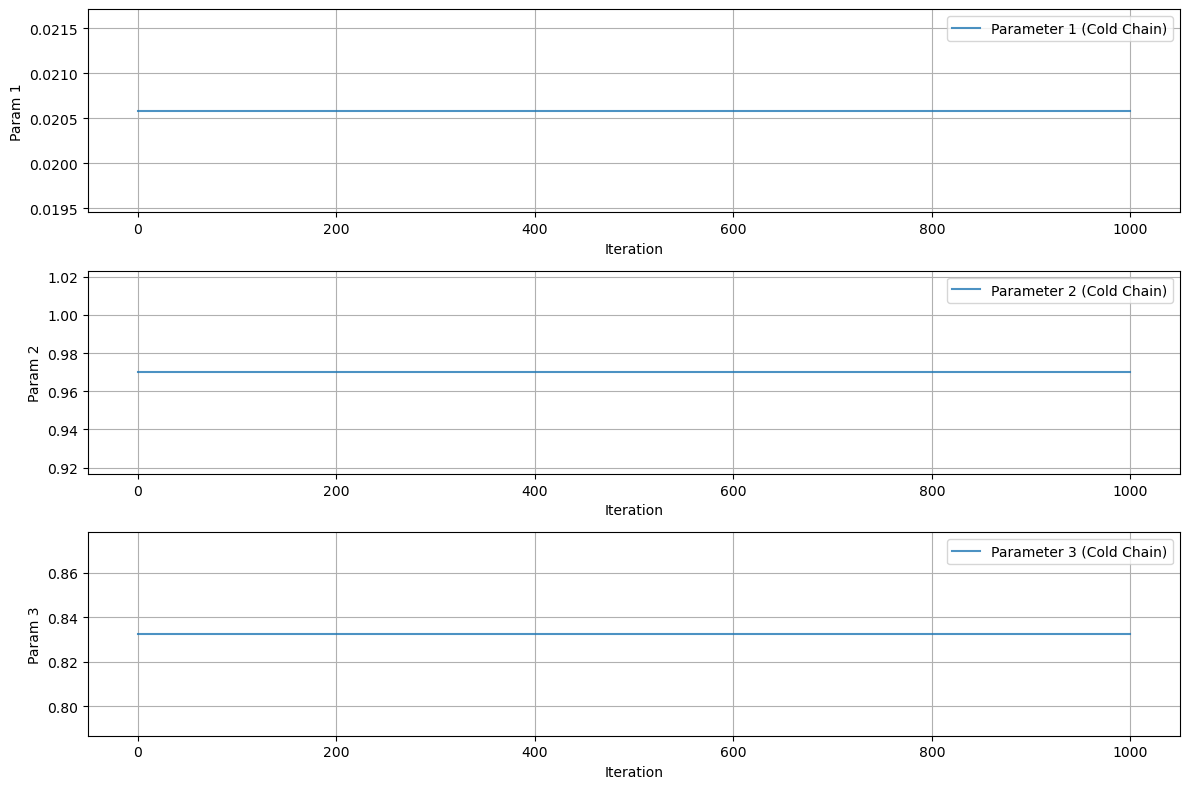

In [10]:
# Example: Assume `samples` has shape (n_temps, n_iter, n_params)
# cold_chain = sampler._chain[0, :, :]  # Select the coldest chain (temperature 0)

# Access the chain
if len(sampler._chain.shape) == 2:  # Single-temperature sampler
    cold_chain = sampler._chain  # Shape: [n_iter, n_params]
elif len(sampler._chain.shape) == 3:  # Parallel tempering
    cold_chain = sampler._chain[0, :, :]  # Coldest chain
else:
    raise ValueError(f"Unexpected chain shape: {sampler._chain.shape}")

n_iter, n_params = cold_chain.shape

# Plot the MCMC chains
plt.figure(figsize=(12, 8))
for i in range(n_params):
    plt.subplot(n_params, 1, i + 1)
    plt.plot(cold_chain[:, i], alpha=0.8, label=f"Parameter {i+1} (Cold Chain)")
    plt.xlabel("Iteration")
    plt.ylabel(f"Param {i+1}")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
